ЦЕЛЬ
Исследовать поведение пользователей в обновлённом приложении.

ЗАДАЧИ
В рамках проверки гипотез необходимо решить три задачи:

1. Определить, насколько обучение сокращает время прохождения этапов игры.
2. Доказать, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.
3. Определить, насколько прозрачен процесс взаимодействия с игрой.

ФОРМАЛИЗОВАННЫЕ ЗАДАЧИ
1. Сравнить время прохождения различных этапов для пользователей, которые завершили обучение, и пользователей, не начинавших обучение. Если показатель отличается, выяснить, насколько.
2. Проверить, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь. 
3. Выяснить, как часто пользователи начинают обучение после выбора уровня сложности. (Это позволит оценить прозрачность процесса взаимодействия с игрой: если пользователи после выбора уровня сложности обращаются к обучению, значит, работа с приложением непонятна.)

Импортируем нужные библиотеки

In [1433]:
import pandas as pd
import numpy as np

Получаем данные из базы данных

In [1434]:
events_df = pd.read_csv('7_4_Events.csv')
events = events_df.copy() # создаем копию исходных данных
cond = (events.start_time>='2018-01-01') & (events.start_time<'2019-01-01') & (events.event_type=='registration') #фильтруем данные за 2018 год
registered = events[cond]['user_id'].to_list()
events = events[events.user_id.isin(registered)]
events.start_time = pd.to_datetime(events.start_time, format='%Y-%m-%dT%H:%M:%S') # преобразуем формат даты


purchase_df = pd.read_csv('purchase.csv')
purchase = purchase_df.copy() # создаем копию исходных данных
purchase['event_type'] = 'purchase' # создаем создаем столбец , готовим данные для дальнейшего объединения
purchase.event_datetime = pd.to_datetime(purchase.event_datetime, format='%Y-%m-%dT%H:%M:%S')
purchase1 = purchase[purchase.user_id.isin(registered)]

events = events.rename(columns={"id": "event_id"}) #переименуем столбцы с одинаковым названием
purchase1 = purchase1.rename(columns={"id": "purchase_id"})
total_events = pd.concat([events,purchase1],sort=False)
total_events = total_events.reset_index(drop=True).sort_values('start_time')
total_events.head()


,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,event_datetime,amount
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaT,NaN
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaT,NaN
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaT,NaN
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaT,NaN
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaT,NaN


1. Определим, насколько обучение сокращает время прохождения этапов игры.

In [1435]:
#Создаем единный столбец с данными времени
total_events.start_time = total_events['start_time'].fillna(0)
def time(s):
    if s.start_time != 0:
        return s.start_time
    elif s.start_time== 0:
        s.event_datetime
    return s.event_datetime
time = total_events.apply(lambda s: time(s), axis=1)  
total_events['time'] = time
total_events.head()

,event_id,event_type,selected_level,start_time,tutorial_id,user_id,purchase_id,event_datetime,amount,time
0,80308.0,registration,NaN,2018-01-01 03:48:40,NaN,27832,NaN,NaT,NaN,2018-01-01 03:48:40
1,80309.0,registration,NaN,2018-01-01 04:07:25,NaN,27833,NaN,NaT,NaN,2018-01-01 04:07:25
2,80310.0,registration,NaN,2018-01-01 08:35:10,NaN,27834,NaN,NaT,NaN,2018-01-01 08:35:10
3,80311.0,registration,NaN,2018-01-01 11:54:47,NaN,27835,NaN,NaT,NaN,2018-01-01 11:54:47
4,80312.0,registration,NaN,2018-01-01 13:28:07,NaN,27836,NaN,NaT,NaN,2018-01-01 13:28:07


In [1436]:
#Создаем группировку по пользователям и этапам прохождения
pivot = total_events.pivot_table(values='time', index = 'user_id', columns = 'event_type',aggfunc='min')
pivot = pivot.copy()
pivot.head()

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start
user_id,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40


In [1437]:
# Вычисляем разницу во времни между этапами по каждому пользователю
pivot['timedelta_tutorial_start'] = (pivot['tutorial_start'] - pivot['registration'])
pivot['timedelta_tutorial_finish'] = (pivot['tutorial_finish'] - pivot['tutorial_start'])
pivot['timedelta_level_choice'] = (pivot['level_choice'] - pivot['tutorial_finish'])
pivot['timedelta_pack_choice'] = (pivot['pack_choice'] - pivot['level_choice'])
pivot['timedelta_purchase'] = (pivot['purchase'] - pivot['pack_choice'])
pivot['timedelta_level_choice2'] = (pivot['level_choice'] - pivot['registration'])
pivot['timedelta_tutorial_start2'] = (pivot['level_choice'] - pivot['tutorial_start'])

pivot.head()
#pivot.info()

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,timedelta_tutorial_start,timedelta_tutorial_finish,timedelta_level_choice,timedelta_pack_choice,timedelta_purchase,timedelta_level_choice2,timedelta_tutorial_start2
user_id,,,,,,,,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,0 days 13:40:15,0 days 00:02:28,NaT,NaT,NaT,NaT,NaT
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,0 days 11:11:01,0 days 00:01:50,NaT,NaT,NaT,NaT,NaT
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 03:06:04,0 days 00:05:24,0 days 05:31:07,0 days 00:01:21,NaT,0 days 08:42:35,0 days 05:36:31
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,0 days 01:26:33,0 days 00:48:18,NaT,NaT,NaT,NaT,NaT


In [1438]:
#Найдем пользователей, которые не пиступали к обучению
pivot.tutorial_start = pivot['tutorial_start'].fillna(0)
pivot_tutorial_start_nou= pivot[pivot['tutorial_start'] == 0]

pivot_tutorial_start_nou.head()

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,timedelta_tutorial_start,timedelta_tutorial_finish,timedelta_level_choice,timedelta_pack_choice,timedelta_purchase,timedelta_level_choice2,timedelta_tutorial_start2
user_id,,,,,,,,,,,,,
27832,NaT,NaT,NaT,2018-01-01 03:48:40,NaT,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
27837,NaT,NaT,NaT,2018-01-01 14:08:40,NaT,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
27838,NaT,NaT,NaT,2018-01-01 14:42:58,NaT,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
27844,NaT,NaT,NaT,2018-01-02 00:13:22,NaT,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT
27848,NaT,NaT,NaT,2018-01-02 06:05:02,NaT,0,NaT,NaT,NaT,NaT,NaT,NaT,NaT


In [1439]:
#Найдем пользователей, которые прошли обучению
pivot.tutorial_start = pivot['tutorial_start'].fillna(0)
pivot_tutorial_start= pivot[pivot['tutorial_start'] != 0]

pivot_tutorial_start.head()

event_type,level_choice,pack_choice,purchase,registration,tutorial_finish,tutorial_start,timedelta_tutorial_start,timedelta_tutorial_finish,timedelta_level_choice,timedelta_pack_choice,timedelta_purchase,timedelta_level_choice2,timedelta_tutorial_start2
user_id,,,,,,,,,,,,,
27833,NaT,NaT,NaT,2018-01-01 04:07:25,2018-01-01 17:50:08,2018-01-01 17:47:40,0 days 13:40:15,0 days 00:02:28,NaT,NaT,NaT,NaT,NaT
27834,NaT,NaT,NaT,2018-01-01 08:35:10,2018-01-01 19:48:01,2018-01-01 19:46:11,0 days 11:11:01,0 days 00:01:50,NaT,NaT,NaT,NaT,NaT
27835,2018-01-01 20:37:22,2018-01-01 20:38:43,NaT,2018-01-01 11:54:47,2018-01-01 15:06:15,2018-01-01 15:00:51,0 days 03:06:04,0 days 00:05:24,0 days 05:31:07,0 days 00:01:21,NaT,0 days 08:42:35,0 days 05:36:31
27836,NaT,NaT,NaT,2018-01-01 13:28:07,2018-01-01 15:42:58,2018-01-01 14:54:40,0 days 01:26:33,0 days 00:48:18,NaT,NaT,NaT,NaT,NaT
27839,2018-01-01 22:37:50,2018-01-01 22:42:54,NaT,2018-01-01 18:24:01,2018-01-01 19:16:32,2018-01-01 19:11:36,0 days 00:47:35,0 days 00:04:56,0 days 03:21:18,0 days 00:05:04,NaT,0 days 04:13:49,0 days 03:26:14


Определим временные интервалы для получившихся групппользователей по этапам

In [1440]:
c2 = pivot_tutorial_start_nou['timedelta_level_choice2'].mean()
d2 = pivot_tutorial_start_nou['timedelta_pack_choice'].mean()
e2 = pivot_tutorial_start_nou['timedelta_purchase'].mean()
print('Пользователи не проходившие обучение:время прохождения этапа между регистрацией и выбором уровня сложности -', c2)
print('Пользователи не проходившие обучение:время прохождения этапа между выбором уровня сложности и выбором пакета -', d2)
print('Пользователи не проходившие обучение:время прохождения этапа между выбором пакета и оплатой -', e2)
print('Пользователи не проходившие обучение:время прохождения этапа между регистрацией и оплатой -', c2+d2+e2)


Пользователи не проходившие обучение:время прохождения этапа между регистрацией и выбором уровня сложности - 0 days 05:15:33.122448979
Пользователи не проходившие обучение:время прохождения этапа между выбором уровня сложности и выбором пакета - 0 days 00:05:23.824324324
Пользователи не проходившие обучение:время прохождения этапа между выбором пакета и оплатой - 4 days 04:49:33.590909090
Пользователи не проходившие обучение:время прохождения этапа между регистрацией и оплатой - 4 days 10:10:30.537682393


In [1441]:
a1 = pivot_tutorial_start['timedelta_tutorial_start'].mean()
b1 = pivot_tutorial_start['timedelta_tutorial_finish'].mean()
c1 = pivot_tutorial_start['timedelta_level_choice'].mean()
d1 = pivot_tutorial_start['timedelta_pack_choice'].mean()
e1 = pivot_tutorial_start['timedelta_purchase'].mean()

print('Пользователи проходившие обучение:время прохождения этапа между регистрацией и выбором уровня сложности -', a1 + b1 +c1, ':')
print('                                              между регистрацией и началом обучения -', a1)
print('                                              между началом обучения и окончанием -', b1)
print('                                              между окончанием и выбором уровня сложности -', c1)
print('                                              между регистрацией и выбором уровня сложности -', a1 + c1)

print('Пользователи проходившие обучение:время прохождения этапа между выбором уровня сложности и выбором пакета -', d1)
print('Пользователи проходившие обучение:время прохождения этапа между выбором пакета и оплатой -', e1)
print('Пользователи проходившие обучение:время прохождения этапа между регистрацией и оплатой -', a1+b1+c1+d1+e1)


Пользователи проходившие обучение:время прохождения этапа между регистрацией и выбором уровня сложности - 0 days 07:10:24.802411865 :
                                              между регистрацией и началом обучения - 0 days 04:38:24.019817844
                                              между началом обучения и окончанием - 0 days 00:12:13.823121951
                                              между окончанием и выбором уровня сложности - 0 days 02:19:46.959472070
                                              между регистрацией и выбором уровня сложности - 0 days 06:58:10.979289914
Пользователи проходившие обучение:время прохождения этапа между выбором уровня сложности и выбором пакета - 0 days 00:05:17.040967684
Пользователи проходившие обучение:время прохождения этапа между выбором пакета и оплатой - 3 days 17:37:39.078580481
Пользователи проходившие обучение:время прохождения этапа между регистрацией и оплатой - 4 days 00:53:20.921960030


In [1442]:
print('Разница во времени между регистрацией и выбором уровня сложности -', a1+b1+c1-c2)
print('Разница во времени между выбором уровня сложности и выбором пакета -', d2-d1)
print('Разница во времени между выбором пакета и оплатой -', e2-e1)
print('Разница во времени прохождения всех этапов между разными группами пользователей -', c2+d2+e2-(a1+b1+c1+d1+e1))

Разница во времени между регистрацией и выбором уровня сложности - 0 days 01:54:51.679962886
Разница во времени между выбором уровня сложности и выбором пакета - 0 days 00:00:06.783356640
Разница во времени между выбором пакета и оплатой - 0 days 11:11:54.512328609
Разница во времени прохождения всех этапов между разными группами пользователей - 0 days 09:17:09.615722363


Вывод: Пользователи прошедшие обучение больше тратят времени (на 1 час 54 минуты) между регистрацие и выбором уровня сложности, даже при вычете времени обучения. Не смотря на это обученные пользователи приступают к оплате быстрее (на 11 часов 11 минут), что отражается на времени прохождения всего периода от регистрации до оплаты. У обученых пользователей это время меньше на 9 часов 17 минут. Отсюда можно сделать вывод, что обучение влияет на скорость получения платежей.

2. Докажем, что успешное обучение само по себе влияет на оплату и не имеет значения то, каким этапом оно шло.

Провериv, существует ли зависимость между вероятностью оплаты вопросов и количеством обучений, которые начинал или завершал пользователь

<ipython-input-1443-c779a5de650b>:10: FutureWarning:

Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.



   start_time  user_id  event_datetime      %
0           1     9103            1207  13.26
1           2     1589             218  13.72
2           3      427              51  11.94
3           4      221              30  13.57
4           5      109              16  14.68
5           6      116              14  12.07
6           7       94              12  12.77
7           8       86              13  15.12
8           9      113              17  15.04


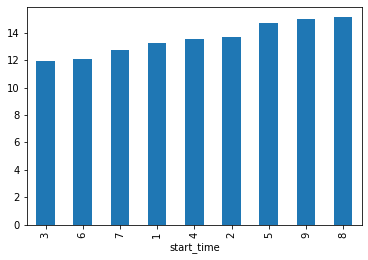

In [1443]:
events1 = events
events2 = events1[events1["event_type"] == "tutorial_start"]
a = events2.user_id.unique
events2 = events2.groupby(
    ['user_id'], 
    as_index=False
)['start_time'].count()
df =pd.merge(events2, purchase1, how='left')
#display(df)
df1 = df.groupby(
    ['start_time'], 
    as_index=False
)['user_id', 'event_datetime'].count()
df1['%'] = (round(df1['event_datetime'] / df1['user_id']*100,2))

print(df1)
grouped = df1.groupby(['start_time'])['%'].last().nsmallest(9).plot(kind='bar')

Как видно из графика явной закономерности  между количеством пройденных обучений и вероятностью оплаты нет.

In [1444]:
#pivot_tutorial_start_nou.purchase = pivot_tutorial_start_nou['purchase'].fillna(0)
b= pivot_tutorial_start_nou.timedelta_purchase.count()
a= pivot_tutorial_start_nou.registration.count()
print('Процент оплативших пользователей не прошедших обучение', round(b/a*100,2),'%')
print(a)
print(b)

Процент оплативших пользователей не прошедших обучение 0.27 %
8068
22


In [1445]:
pivot_tutorial_start.purchase = pivot_tutorial_start['purchase'].fillna(0)
pivot_tutorial_start.tutorial_start = pivot_tutorial_start['tutorial_start'].fillna(0)
pivot_tutorial_start.tutorial_finish = pivot_tutorial_start['tutorial_finish'].fillna(0)
b= pivot_tutorial_start.timedelta_purchase.count()
c = pivot_tutorial_start.timedelta_tutorial_start.count()
d = pivot_tutorial_start.timedelta_tutorial_finish.count()
a= pivot_tutorial_start.registration.count()
print('Процент оплативших пользователей прошедших обучение', round(b/a*100,2),'%')
print('Количество пользователей начавших обучение', c)
print('Количество пользователей оплативших обучение', b)
print('Количество пользователей завершивших обучение', d)
print('Количество пользователей не завершивших обучение',c-d)

Процент оплативших пользователей прошедших обучение 13.31 %
Количество пользователей начавших обучение 11858
Количество пользователей оплативших обучение 1578
Количество пользователей завершивших обучение 10250
Количество пользователей не завершивших обучение 1608


C:\Users\Elizaveta\anaconda3\lib\site-packages\pandas\core\generic.py:5494: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Как видно из полученных данных чаще платят пользователи прошедшие обучение. Не все пользователи приступившие к обучению его завершают.


Определим какие пользователи платят чаще: завершившие обучение или не завершившие

In [1446]:
tutorial_finish_count_nou = pivot_tutorial_start[pivot_tutorial_start.tutorial_finish == 0].timedelta_purchase.count()
tutorial_finish_count = pivot_tutorial_start[pivot_tutorial_start.tutorial_finish != 0].timedelta_purchase.count()
print('Количество пользователей оплативших обучение, но не завершивших его',tutorial_finish_count_nou)
print('Количество пользователей оплативших и завершивших обучение',tutorial_finish_count)

Количество пользователей оплативших обучение, но не завершивших его 131
Количество пользователей оплативших и завершивших обучение 1447


Как мы видим чаще платят пользователи завершившие обучение. Определим % оплативших пользователей по группам.

In [1447]:
count_nou = tutorial_finish_count_nou / (c-d) *100
count_es = tutorial_finish_count / d *100
print('% пользователей оплативших обучение от не завершивших его',round(count_nou, 2), '%')
print('% пользователей оплативших от завершивших обучение', round(count_es, 2), '%')
print('% пользователей приступивших к обучению и оплативших составляет',round((1447 +131)/1600*100,2))

% пользователей оплативших обучение от не завершивших его 8.15 %
% пользователей оплативших от завершивших обучение 14.12 %
% пользователей приступивших к обучению и оплативших составляет 98.62


Вывод: 131 из 1608 принимает решение, что игра ему интересна еще не завершив обучение (8,15%)
1447 из 10250 принимает решение, что игра ему интересна по окончанию обучения (14,12%)
Очевидно есть проблемы с прохождением обучения. Оно не мотевирует пользователей к оплате. 
Это наиболее очевидно, если учесть, что наибольшее количество плательщиков среди тех, кто приступил к обучению (98,62 %).
Есть вероятность, что обучение некачествено разработано, поскольку пятая часть пользователь проходит обучение по несколько раз и даже после 9 обучений процент оплат очень низкий.

3. Определим, насколько прозрачен процесс взаимодействия с игрой.

In [1448]:
level_choice = total_events[total_events['event_type'] == 'level_choice']
utorial_finish = total_events[total_events['event_type'] == 'tutorial_start']

df =pd.merge(level_choice, utorial_finish, on = 'user_id')
df['timedelta_time'] = (df['time_x'] - df['time_y'])
df=df[df['timedelta_time'] < pd.Timedelta(0)]
df#.info()
df = df.groupby(
    ['user_id'], 
    as_index=False
)['timedelta_time'].count()
df1 = df.groupby(
    ['timedelta_time'], 
    as_index=False
)['user_id'].count()
a =df.timedelta_time.count()
b =total_events[total_events['event_type'] == 'level_choice'].user_id.count()
print('% пользователей начинающих обучение после выбора уровня сложности', round(a/b*100,2), '%')
df1


% пользователей начинающих обучение после выбора уровня сложности 16.61 %


,timedelta_time,user_id
0,1,819
1,2,229
2,3,116
3,4,77
4,5,57
5,6,51
6,7,28
7,8,9


Вывод: Как видно из расчетов 16,61% пользователей выбравших уровень сложности возвращаются к обучению, при этом третья часть из них по несколько раз. Это говорит о том, что работа с приложением непонятна, а так же подтверждает тот факт, что обучение недоработано.